In [1]:
import numpy as np
import sklearn
import os
from PIL import Image
import os
import matplotlib.pyplot as plt
from multiprocessing import Process

Ordner aus Verzeichnis holen

In [ ]:
# Pfad zu Ihrem Hauptverzeichnis mit Bildern
path = "C:/Users/a829727/Downloads"

# Erstellen von Ausgabeordnern
horizontal_folder = "./data/horizontal/"
vertical_folder = "./data/vertical/"
if not os.path.exists(horizontal_folder):
    os.makedirs(horizontal_folder)
if not os.path.exists(vertical_folder):
    os.makedirs(vertical_folder)

# Schleife durch alle Bilder im Verzeichnis und allen Unterordnern
for root, dirs, files in os.walk(path):
    for file in files:
        # Überprüfen, ob das aktuelle Element eine Bilddatei ist und die Endung .jpg hat
        if file.endswith(".jpg"):
            # Öffnen des Bilds mit der Python Imaging Library (PIL)
            img = Image.open(os.path.join(root, file))
            # Überprüfen, ob das Bild breiter als hoch ist
            if img.width > img.height:
                # Bild in horizontalen Ordner kopieren
                img.save(os.path.join(horizontal_folder, file))
            else:
                # Bild in vertikalen Ordner kopieren
                img.save(os.path.join(vertical_folder, file))


### Datenverteilung

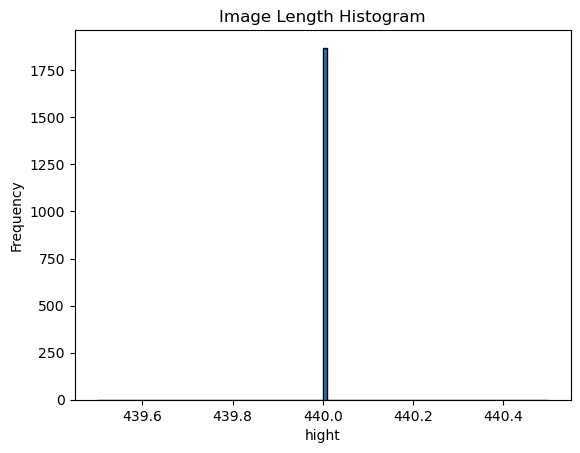

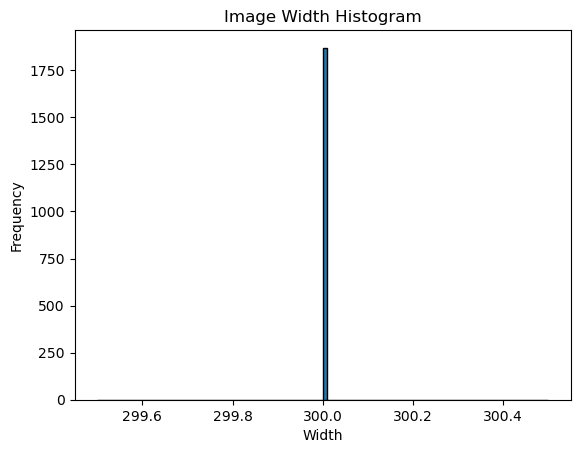

In [7]:
def get_image_dimensions(folder_path):
    image_dimensions = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            filepath = os.path.join(folder_path, filename)
            with Image.open(filepath) as img:
                width, height = img.size
                image_dimensions.append((width, height))
    return image_dimensions

def create_histogram(data, title, xlabel, ylabel, direction): 
    values = [item[direction] for item in data]  # direction 0= witht und 1= hight
    plt.hist(values, bins=100, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

folder_path = "./data/data_final/"
image_dimensions = get_image_dimensions(folder_path)

create_histogram(image_dimensions, "Image Length Histogram", "hight", "Frequency",1)
create_histogram(image_dimensions, "Image Width Histogram", "Width", "Frequency",0)


Aussortieren der zu kleinen Bilder

In [4]:
# Pfad zum Verzeichnis
dir_path = "./data/vertical/"

path_list=[]
# Durchlaufe alle Dateien im Verzeichnis
for filename in os.listdir(dir_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(dir_path, filename)
        # Öffne das Bild und erhalte seine Dimensionen
        with Image.open(img_path) as img:
            width, height = img.size
            # Wenn die Dimensionen kleiner sind als gefordert, lösche die Datei
            if width < 300 or height < 440:
                path_list.append(img_path)
                print(f"Datei {filename} wurde zum Abschuss freigegeben :D")

for path in path_list:
    os.remove(path)

Datei img_10.jpg wurde zum Abschuss freigegeben :D
Datei img_1003.jpg wurde zum Abschuss freigegeben :D
Datei img_1004.jpg wurde zum Abschuss freigegeben :D
Datei img_10094.jpg wurde zum Abschuss freigegeben :D
Datei img_1011.jpg wurde zum Abschuss freigegeben :D
Datei img_1012_1.jpg wurde zum Abschuss freigegeben :D
Datei img_1013.jpg wurde zum Abschuss freigegeben :D
Datei img_1016.jpg wurde zum Abschuss freigegeben :D
Datei img_1019.jpg wurde zum Abschuss freigegeben :D
Datei img_102.jpg wurde zum Abschuss freigegeben :D
Datei img_1021.jpg wurde zum Abschuss freigegeben :D
Datei img_1032.jpg wurde zum Abschuss freigegeben :D
Datei img_1034.jpg wurde zum Abschuss freigegeben :D
Datei img_10344.jpg wurde zum Abschuss freigegeben :D
Datei img_1035.jpg wurde zum Abschuss freigegeben :D
Datei img_1035_1.jpg wurde zum Abschuss freigegeben :D
Datei img_1035_2.jpg wurde zum Abschuss freigegeben :D
Datei img_1036.jpg wurde zum Abschuss freigegeben :D
Datei img_1037.jpg wurde zum Abschuss fre

Zuschneiden der Bilder

In [6]:
# Pfad zum Eingangs- und Ausgangsverzeichnis
input_dir_path = "./data/vertical/"
output_dir_path = "./data/data_final"

# Falls das Ausgangsverzeichnis nicht existiert, erstelle es
if not os.path.exists(output_dir_path):
    os.makedirs(output_dir_path)

# Durchlaufe alle Dateien im Verzeichnis
for filename in os.listdir(input_dir_path):
    if filename.endswith(".jpg"):
        img_path = os.path.join(input_dir_path, filename)
        # Öffne das Bild und erhalte seine Dimensionen
        with Image.open(img_path) as img:
            width, height = img.size
            # Schneide das Bild zu
            left = (width - 300)/2
            top = max(0, height - 440)  # Falls das Bild weniger als 440 hoch ist, fange oben an
            right = (width + 300)/2
            bottom = height
            img_cropped = img.crop((left, top, right, bottom))
            # Speichere das zugeschnittene Bild im Ausgangsverzeichnis
            img_cropped.save(os.path.join(output_dir_path, filename))
            print(f"Datei {filename} wurde zugeschnitten und gespeichert.")


Datei img_1.jpg wurde zugeschnitten und gespeichert.
Datei img_100.jpg wurde zugeschnitten und gespeichert.
Datei img_1000.jpg wurde zugeschnitten und gespeichert.
Datei img_1001.jpg wurde zugeschnitten und gespeichert.
Datei img_1003_1.jpg wurde zugeschnitten und gespeichert.
Datei img_1005.jpg wurde zugeschnitten und gespeichert.
Datei img_1006.jpg wurde zugeschnitten und gespeichert.
Datei img_1007.jpg wurde zugeschnitten und gespeichert.
Datei img_1009.jpg wurde zugeschnitten und gespeichert.
Datei img_1010.jpg wurde zugeschnitten und gespeichert.
Datei img_1014_1.jpg wurde zugeschnitten und gespeichert.
Datei img_1015.jpg wurde zugeschnitten und gespeichert.
Datei img_1017.jpg wurde zugeschnitten und gespeichert.
Datei img_1018.jpg wurde zugeschnitten und gespeichert.
Datei img_1020.jpg wurde zugeschnitten und gespeichert.
Datei img_10211.jpg wurde zugeschnitten und gespeichert.
Datei img_1021_1.jpg wurde zugeschnitten und gespeichert.
Datei img_1022.jpg wurde zugeschnitten und ge